# MetPy Case Study


In [1]:
import numpy as np
from metpy.units import units
from pyproj import Geod
# Helper function to calculate distance between lat/lon points
# to be used in differencing calculations
def calc_dx_dy2(longitude,latitude,shape='sphere',radius=6370997.):
    ''' This definition calculates the distance between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D or 2D arrays for latitude and longitude
        
        Assumes [Y, X] for 2D arrays
        
        Returns: dx, dy; 2D arrays of distances between grid points 
                 in the x and y direction with units of meters 
    '''
    import numpy as np
    from metpy.units import units
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(ellps=shape, a=radius, b=radius)
    else:
        g = Geod(ellps=shape)
    
    if (latitude.ndim == 1):
        longitude, latitude = np.meshgrid(longitude,latitude)
    
    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)
        
    _, _, dy[:-1,:] = g.inv(longitude[:-1,:],latitude[:-1,:],longitude[1:,:],latitude[1:,:])
    dy[-1,:] = dy[-2,:]
    
    _, _, dx[:,:-1] = g.inv(longitude[:,:-1],latitude[:,:-1],longitude[:,1:],latitude[:,1:])
    dx[:,-1] = dx[:,-2]
    
    xdiff_sign = np.sign(longitude[0,1]-longitude[0,0])
    ydiff_sign = np.sign(latitude[1,0]-latitude[0,0])
    return xdiff_sign*dx*units.meter, ydiff_sign*dy*units.meter

def calc_dx_dy(longitude, latitude, **kwargs):
    r"""Calculate the distance between grid points that are in a latitude/longitude format.
    Calculate the distance between grid points when the grid spacing is defined by
    delta lat/lon rather than delta x/y
    Parameters
    ----------
    longitude : array_like
        array of longitudes defining the grid
    latitude : array_like
        array of latitudes defining the grid
    kwargs
        Other keyword arguments to pass to :class:`~pyproj.Geod`
    Returns
    -------
     dx, dy: 2D arrays of distances between grid points in the x and y direction
    Notes
    -----
    Accepts, 1D or 2D arrays for latitude and longitude
    Assumes [Y, X] for 2D arrays
    """
    # Inputs must be the same number of dimensions
    if latitude.ndim != longitude.ndim:
        raise ValueError('Latitude and longitude must have the same number of dimensions.')

    # If we were given 1D arrays, make a mesh grid
    if latitude.ndim == 1:
        longitude, latitude = np.meshgrid(longitude, latitude)

    geod_args = {'ellps': 'sphere'}
    geod_args.update(**kwargs)
    g = Geod(**geod_args)

    _, _, dy = g.inv(longitude[:-1, :], latitude[:-1, :], longitude[1:, :], latitude[1:, :])
    _, _, dx = g.inv(longitude[:, :-1], latitude[:, :-1], longitude[:, 1:], latitude[:, 1:])

    return dx * units.meter, dy * units.meter

In [2]:
from siphon.ncss import NCSS
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime
from netCDF4 import Dataset, num2date
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
from metpy.plots import SkewT
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from scipy.ndimage import gaussian_filter


## Case Study Data

In [3]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 0

dt = datetime(year,month,day,hour)

In [4]:
# Read NARR Data from THREDDS server
ncss = NCSS('http://nomads.ncdc.noaa.gov/thredds/ncss/grid/narr-a/'+dt.strftime('%Y%m')+
            '/'+dt.strftime('%Y%m%d')+'/narr-a_221_'+dt.strftime('%Y%m%d')+'_'+dt.strftime('%H')+'00_000.grb')
query = ncss.query().lonlat_box(north=60, south=18, east=300, west=225)
query.all_times().variables('Geopotential_height','u_wind','v_wind',
                            'Temperature').add_lonlat().accept('netcdf4')
data = ncss.get_data(query)

## Pulling Data for Calculation/Plotting

In [19]:
# Read local netCDF file of NARR data
#data = Dataset('NARR_19930313_0000.nc','r')

# Grab data and assign units
tmpk = gaussian_filter(data.variables['Temperature'][0], sigma=1.0) * units.K
hght = gaussian_filter(data.variables['Geopotential_height'][0], sigma=1.0) * units.meter
uwnd = gaussian_filter(data.variables['u_wind'][0], sigma=1.0) * units('m/s')
vwnd = gaussian_filter(data.variables['v_wind'][0], sigma=1.0) * units('m/s')

# Grab data for plotting
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lev = data.variables['isobaric'][:]
time = data.variables['time']
vtime = num2date(time[0],units=time.units)

# Calcualte dx and dy for calculations
dx, dy = calc_dx_dy2(lon, lat)

(118, 268) (118, 268)
[[ 28347.86970019  28369.92084656  28391.75548146 ...,  26644.89828247   26610.55234895  26576.02811233] [ 28403.78501154  28425.83480186  28447.66749404 ...,  26699.4718184   26665.07576048  26630.50042055] [ 28459.47956711  28481.52645946  28503.35566881 ...,  26753.91208383   26719.46716937  26684.84198527] ...,  [ 32418.54419702  32424.19159386  32429.54331326 ...,  31441.32829888   31413.5133766   31385.31522967] [ 32426.42837713  32431.73127085  32436.73704147 ...,  31465.66838881   31438.04298147  31410.03138973] [ 32426.42837713  32431.73127085  32436.73704147 ...,  31465.66838881   31438.04298147  31410.03138973]] meter


## Finding Pressure Level Data

In [22]:
# Specify 850 hPa data
ilev850 = np.where(lev == 850)[0][0]
hght_850 = hght[ilev850]
tmpk_850 = tmpk[ilev850]
uwnd_850 = uwnd[ilev850]
vwnd_850 = vwnd[ilev850]

In [23]:
# Specify 500 hPa data
ilev500 = np.where(lev == 500)[0][0]
hght_500 = hght[ilev500]
uwnd_500 = uwnd[ilev500]
vwnd_500 = vwnd[ilev500]

In [24]:
# Specify 300 hPa data
ilev300 = np.where(lev == 300)[0][0]
hght_300 = hght[ilev300]
uwnd_300 = uwnd[ilev300]
vwnd_300 = vwnd[ilev300]

## Using MetPy to Calculate Atmospheric Dynamic Quantities

In [25]:
# Temperature Advection
tmpc_adv_850 = mpcalc.advection(tmpk_850, [uwnd_850,vwnd_850], (dx, dy), dim_order='yx').to('degC/s')

In [26]:
# Vorticity and Absolute Vorticity Calculations

# Planetary Vorticity
f = mpcalc.coriolis_parameter(np.deg2rad(lat)).to('1/s')

# Relative Vorticity
vor_500 = mpcalc.v_vorticity(uwnd_500, vwnd_500, dx, dy, 
                             dim_order='yx')

# Gaussian smoother of Relative Vorticity
smooth_vor_500 = vor_500.m * units('1/s')

# Abosolute Vorticity
avor_500 = smooth_vor_500 + f

In [27]:
# Vorticity Advection
f_adv = mpcalc.advection(f, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

relvort_adv = mpcalc.advection(smooth_vor_500, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

absvort_adv = mpcalc.advection(avor_500, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

In [28]:
# Stretching Vorticity
div_500 = mpcalc.h_convergence(uwnd_500, vwnd_500, dx, dy, dim_order='yx')

stretch_vort = -1*avor_500*div_500

In [29]:
# Divergence 300 hPa, Ageostrophic Wind
wspd_300 = mpcalc.get_wind_speed(uwnd_300, vwnd_300).to('kts')

div_300 = mpcalc.h_convergence(uwnd_300, vwnd_300, dx, dy, dim_order='yx')
ugeo_300, vgeo_300 = mpcalc.geostrophic_wind(hght_300, f, dx, dy, dim_order='yx')

uageo_300 = uwnd_300 - ugeo_300
vageo_300 = vwnd_300 - vgeo_300

## Maps and Projections

In [21]:
# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100., central_latitude=40.,
                                 standard_parallels=[30,60])
#plotproj = ccrs.PlateCarree(central_longitude=-107.)

states_provinces = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m',
                                             facecolor='none')

In [30]:
def create_map_background():
    fig=plt.figure(1,figsize=(14.,12.))
    ax=plt.subplot(111,projection=plotproj)
    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    return fig, ax

## 850-hPa Temperature Advection

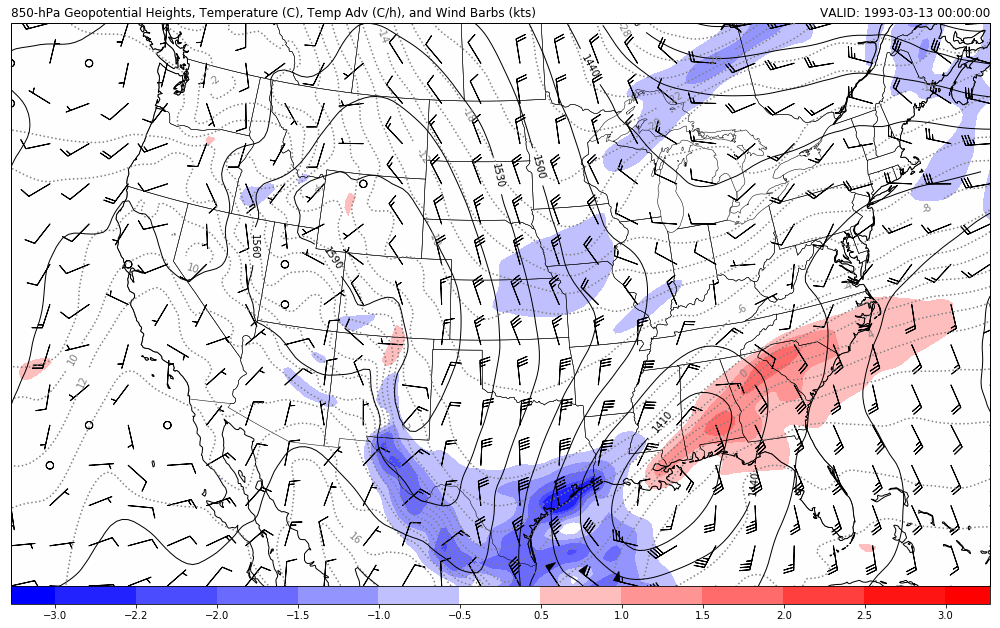

In [34]:
fig, ax = create_map_background()
clev850 = np.arange(0,4000,30)

cs2 = ax.contour(lon,lat,tmpk_850.to('degC'),range(-50,50,2),colors='grey',linestyles='dotted',
                 transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cs = ax.contour(lon,lat,hght_850,clev850,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cf = ax.contourf(lon,lat,tmpc_adv_850*3600,[-3,-2.2,-2,-1.5,-1,-0.5,0.5,1.0,1.5,2.0,2.5,3.0],
                 cmap='bwr',extend='both',transform=dataproj)
plt.colorbar(cf,orientation='horizontal',pad=0.0,aspect=50,extendrect=True,
             ticks=[-3,-2.2,-2,-1.5,-1,-0.5,0.5,1.0,1.5,2.0,2.5,3.0])

ax.barbs(lon,lat,uwnd_850.to('kts').m,vwnd_850.to('kts').m,regrid_shape=15,transform=dataproj)

plt.title('850-hPa Geopotential Heights, Temperature (C), Temp Adv (C/h), and Wind Barbs (kts)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')
plt.tight_layout()
#plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()


## 500-hPa Absolute Vorticity

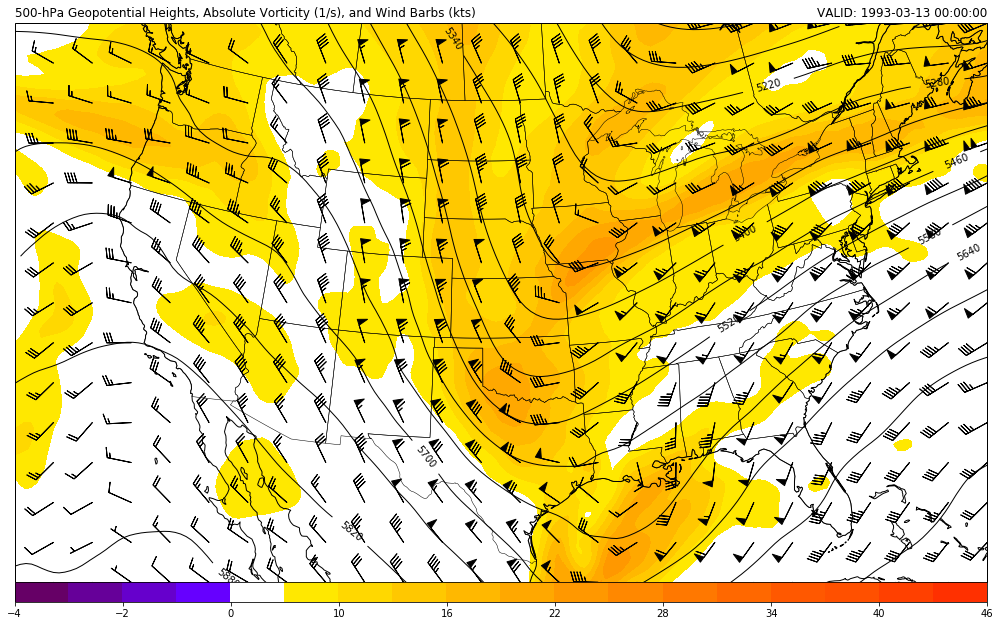

In [32]:
fig, ax = create_map_background()
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Set contour intervals for Absolute Vorticity
clevavor500 = [-4,-3,-2,-1,0,7,10,13,16,19,22,25,28,31,34,37,40,43,46]
# Set colorfill colors for absolute vorticity; purple negative, yellow to orange positive
colorsavor500 = ('#660066', '#660099', '#6600CC', '#6600FF', 'w', '#ffE800', '#ffD800',
                 '#ffC800', '#ffB800', '#ffA800', '#ff9800', '#ff8800', '#ff7800',
                 '#ff6800', '#ff5800', '#ff5000', '#ff4000', '#ff3000')
cf = ax.contourf(lon,lat,avor_500*10**5,clevavor500,colors=colorsavor500,transform=dataproj)
plt.colorbar(cf,orientation='horizontal',pad=0.0,aspect=50)

ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

plt.title('500-hPa Geopotential Heights, Absolute Vorticity (1/s), and Wind Barbs (kts)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')
plt.tight_layout()
#plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()

## 300-hPa Wind Speed, Divergence, and Ageostrophic Wind

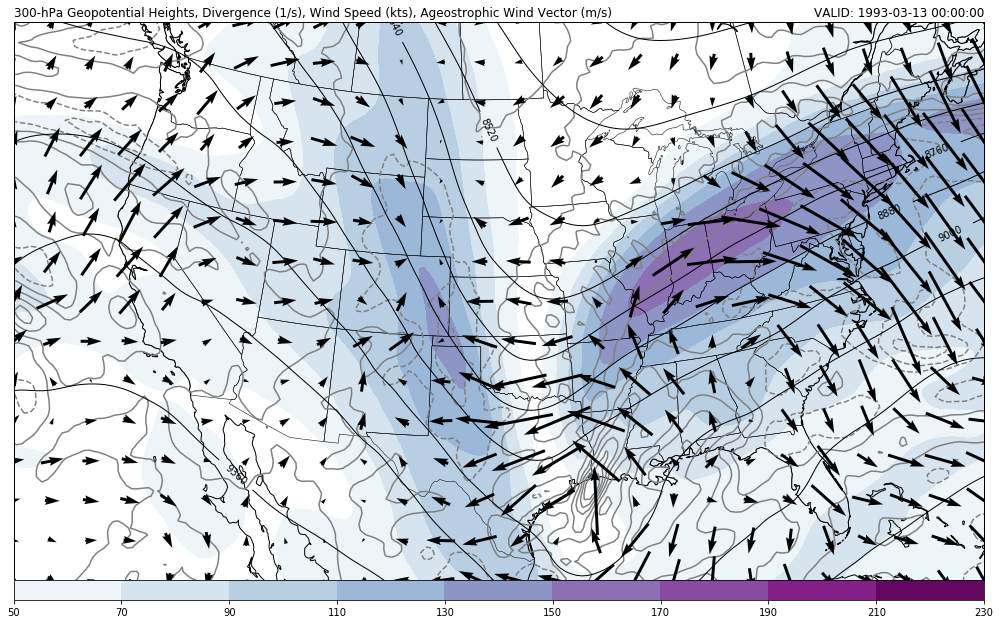

In [33]:
fig, ax = create_map_background()
clev300 = np.arange(0,11000,120)

cs2 = ax.contour(lon,lat,div_300*10**5,range(-10,11,2),colors='grey',transform=dataproj)

cs = ax.contour(lon,lat,hght_300,clev300,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

spd300 = np.arange(50,250,20)
cf = ax.contourf(lon,lat,wspd_300,spd300,cmap='BuPu',transform=dataproj,zorder=0)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50)

ax.quiver(lon,lat,uageo_300.m,vageo_300.m,regrid_shape=15,pivot='mid',transform=dataproj,zorder=10)

plt.title('300-hPa Geopotential Heights, Divergence (1/s), Wind Speed (kts), Ageostrophic Wind Vector (m/s)',
          loc='left')
plt.title('VALID: %s' %(vtime),loc='right')
plt.tight_layout()
#plt.title('VALID: %s' %(vtimes[FH]),loc='right')
plt.show()


## Vorticity Tendency Terms

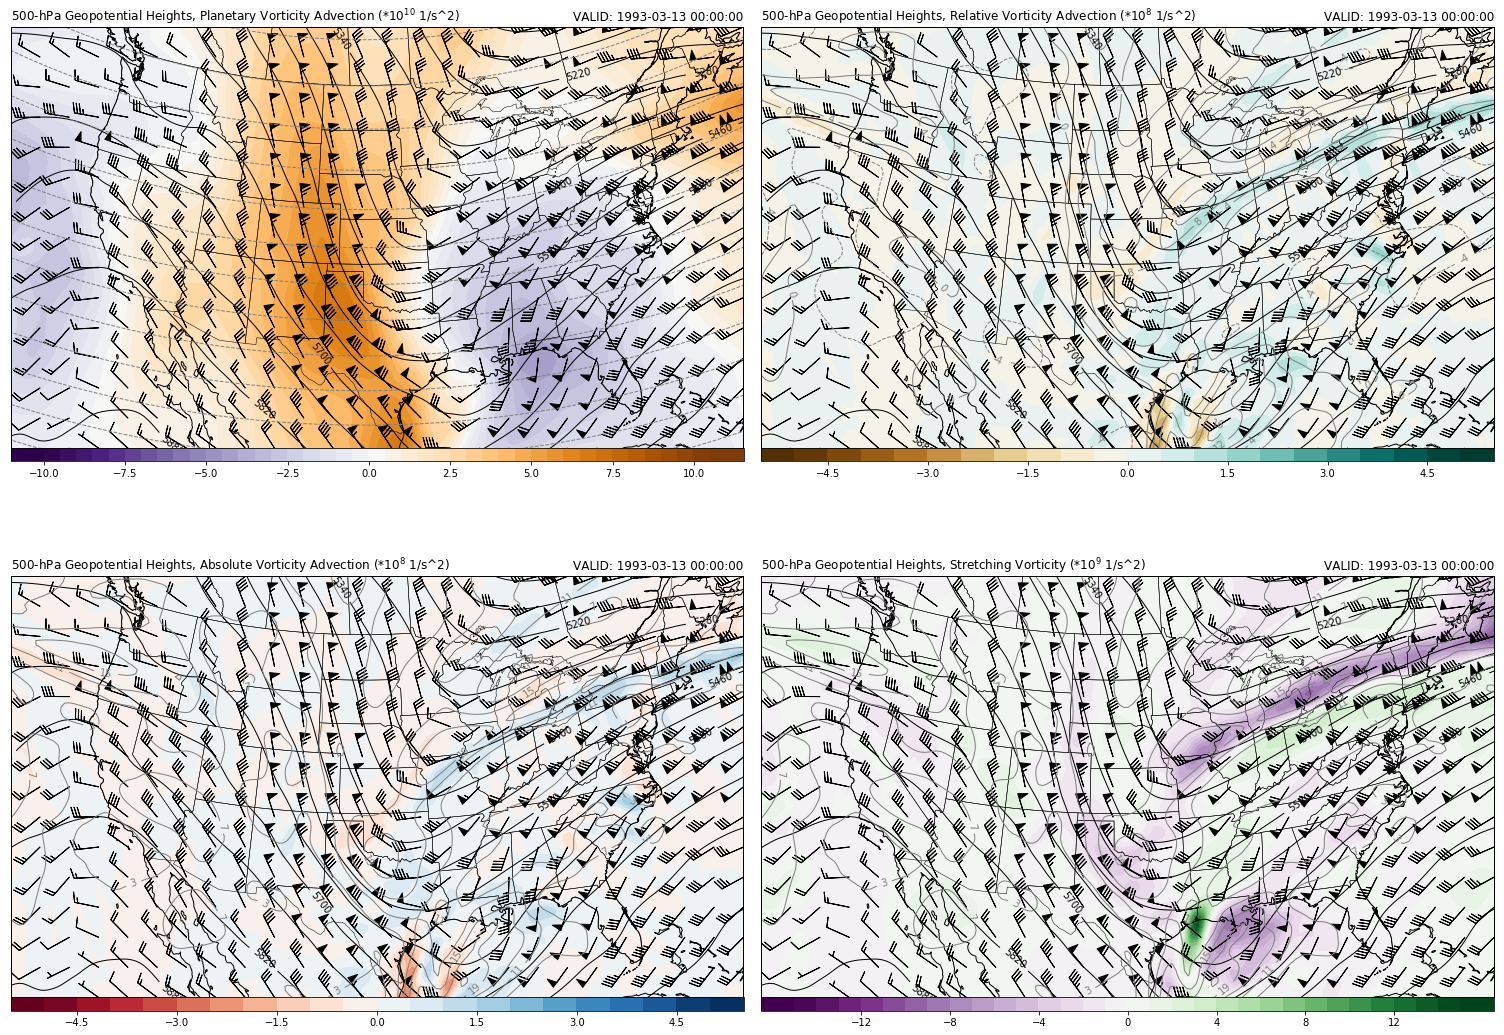

In [36]:
fig=plt.figure(1,figsize=(21.,16.))

# Upper-Left Panel
ax=plt.subplot(221,projection=plotproj)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([360-125.,360-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

cs2 = ax.contour(lon,lat,f*10**4,np.arange(0,3,.05),colors='grey',
                linewidths=1.0,linestyles='dashed',transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%.2f', rightside_up=True, use_clabeltext=True)

cf = ax.contourf(lon,lat,f_adv*10**10,np.arange(-10,11,0.5),
                 cmap='PuOr_r',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

plt.title(r'500-hPa Geopotential Heights, Planetary Vorticity Advection ($*10^{10}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')


# Upper-Right Panel
ax=plt.subplot(222,projection=plotproj)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([360-125.,360-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

cs2 = ax.contour(lon,lat,gaussian_filter(vor_500*10**5,sigma=1.0),np.arange(-40,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

cf = ax.contourf(lon,lat,relvort_adv*10**8,np.arange(-5,5.5,0.5),
                 cmap='BrBG',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

plt.title(r'500-hPa Geopotential Heights, Relative Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

# Lower-Left Panel
ax=plt.subplot(223,projection=plotproj)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([360-125.,360-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

cs2 = ax.contour(lon,lat,gaussian_filter(avor_500*10**5,sigma=1.0),np.arange(-5,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

cf = ax.contourf(lon,lat,absvort_adv*10**8,np.arange(-5,5.5,0.5),
                 cmap='RdBu',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

plt.title(r'500-hPa Geopotential Heights, Absolute Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

# Lower-Right Panel
ax=plt.subplot(224,projection=plotproj)
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([360-125.,360-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

cs2 = ax.contour(lon,lat,gaussian_filter(avor_500*10**5,sigma=1.0),np.arange(-5,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

cf = ax.contourf(lon,lat,gaussian_filter(stretch_vort*10**9,sigma=1.0),np.arange(-15,16,1),
                 cmap='PRGn',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

plt.title(r'500-hPa Geopotential Heights, Stretching Vorticity ($*10^{9}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

## Plotting Data for Hand Calculation



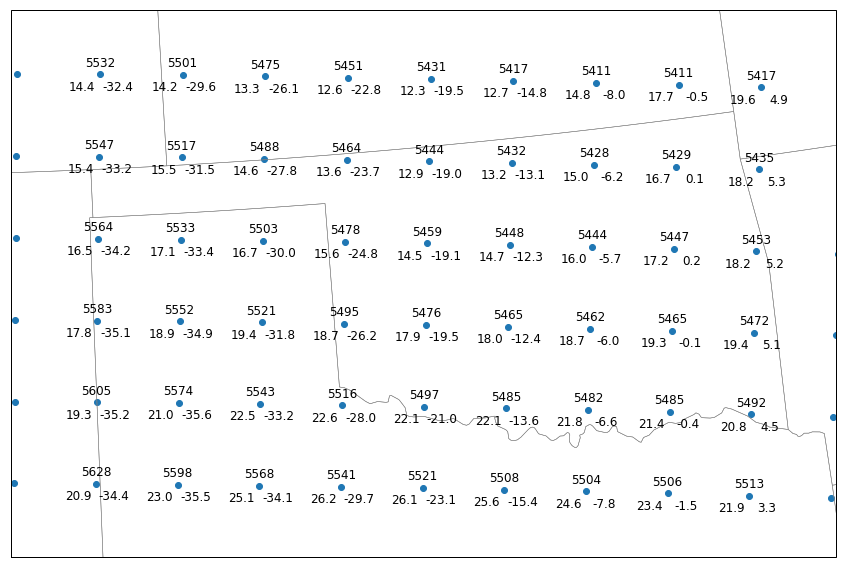

In [126]:
from metpy.plots import StationPlot


LLlon = -104
LLlat = 33
URlon = -94
URlat = 38

fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_latitude=50,central_longitude=-107))

#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LLlon,URlon,LLlat,URlat],ccrs.PlateCarree())

mask_lon = ((lon[::3,::3].ravel() > LLlon+0.05) & (lon[::3,::3].ravel() < URlon+0.01))
mask_lat = ((lat[::3,::3].ravel() < URlat-0.01) & (lat[::3,::3].ravel() > LLlat-0.01))
mask = mask_lon&mask_lat


stationplot = StationPlot(ax, lon[::3,::3].ravel()[mask], lat[::3,::3].ravel()[mask],
                          transform=ccrs.PlateCarree(), fontsize=12)



ax.coastlines('50m',edgecolor='grey',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='grey',linewidth=0.5)




ax.scatter(lon[::3,::3],lat[::3,::3],marker='o',transform=dataproj)
stationplot.plot_parameter((0,1), hght_500[::3,::3].m.ravel()[mask])
stationplot.plot_parameter((-1.5,-1), uwnd_500[::3,::3].m.ravel()[mask], formatter='.1f')
stationplot.plot_parameter((1.5,-1), vwnd_500[::3,::3].m.ravel()[mask], formatter='.1f')

plt.tight_layout()
plt.show()